# Matplotlib and pylab inline

In [44]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import libraries and set rcParams

In [7]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from matplotlib import rcParams
from numpy.random import choice
from modules.filepaths import *


rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = (4, 5)
rcParams['image.cmap'] = 'gray'

# For the first time make fingeprint image read function

In [8]:
# Images types

TYPES = ['.jpg', '.jpeg', '.jpe',
         '.png',
         '.bmp', '.dib',
         '.pbm', '.pgm', '.ppm',
         '.sr', '.ras',
         '.tiff', '.tif']


# Function for checking image type

def check_im_type(name: str):
    """
    check_im_type(name: str) -> bool
    """
    fl = False
    for tp in TYPES:
        if name.endswith(tp):
            fl = True
            break
    return fl


# function for getting

def images_dir_list(listdir):
    return [name for name in listdir if check_im_type(name)]


# Read random function for images

def read_random_image(file_path, with_path=False, flag=cv.IMREAD_GRAYSCALE):
    '''
    read_random_image(file_path, [with_path=False, [flag=cv.IMREAD_GRAYSCALE)
    file_path - file, where images are stored
    with_path - if True return image's filepath and image
    flag - constant values from cv.imread(). Default cv.IMREAD_GREAYSCALE
    '''

    images_list = images_dir_list(os.listdir(file_path))
    image_name = choice(images_list)
    image_path = file_path + image_name

    if with_path:
        return image_path, cv.imread(image_path, flag)
    else:
        return cv.imread(image_path, flag)

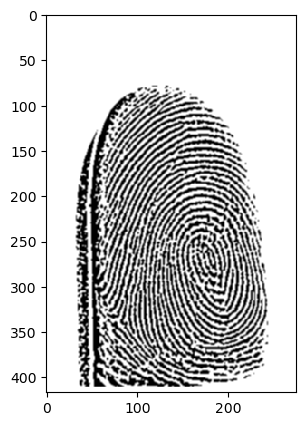

In [14]:

im = read_random_image(RAW_FILE_PATH_GOODIM)
plt.imshow(im)
plt.show()

# Make inverse color function

In [19]:

def invers_color(image):
    if image.mean() > 127.5:
        inv_image = cv.bitwise_not(image)
    else:
        inv_image = image.copy()

    return inv_image

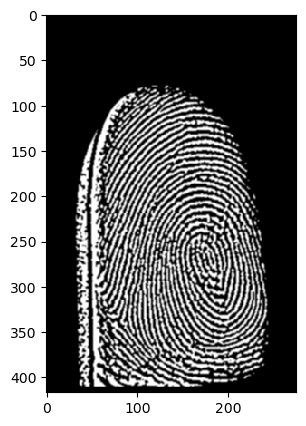

In [20]:

fp_image = invers_color(im)
plt.imshow(fp_image)

# Make function for getting fingerprint image

## Let's show process of cropping fingerprint image

In [22]:

_, contours, hierarchy = cv.findContours(fp_image, cv.RETR_EXTERNAL,
                                         cv.CHAIN_APPROX_SIMPLE)

print("Количество контуров:", len(contours))

Количество контуров: 10


In [25]:
%time

new_contour = np.vstack(contours)
print("\nКоличество точек:", new_contour.shape[0])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs

Количество точек: 998


## Getting a convex hull

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.9 µs

 (417, 276) (32, 78) (246, 412)


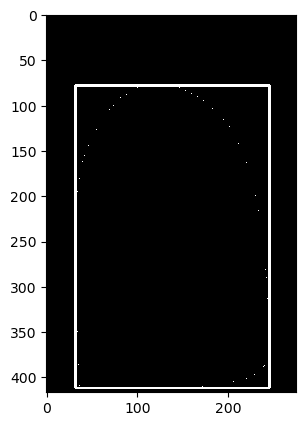

In [31]:
%time

hull = cv.convexHull(new_contour)
BOUND_CONST = 0

x1, y1, width, height = cv.boundingRect(hull)
x2, y2 = x1 + width + BOUND_CONST, y1 + height + BOUND_CONST
x1, y1 = x1 - BOUND_CONST, y1 - BOUND_CONST

if x1 < 0:
    x1 = 0

if y1 < 0:
    y1 = 0

if x2 > fp_image.shape[1]:
    x2 = fp_image.shape[1]

if y2 > fp_image.shape[0]:
    y2 = fp_image.shape[0]

print('\n', fp_image.shape, (x1, y1), (x2, y2))

mask = np.zeros(fp_image.shape)
mask = cv.rectangle(mask, (x1, y1), (x2, y2), 255, 2)

plt.imshow(cv.drawContours(mask, hull, -1, 255), cmap=plt.cm.gray)
pass

# Getting a fingerprint image

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


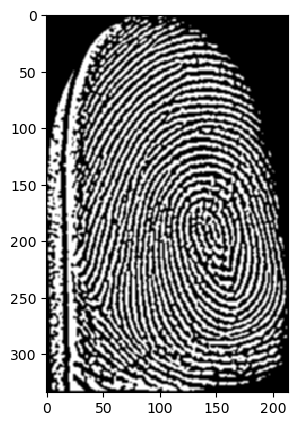

In [32]:
%time

new_image = fp_image[y1:y2, x1:x2]
plt.imshow(new_image, cmap=plt.cm.gray)

pass

# Make function for crop fingerprint image

In [40]:

def crop_fp_image(fp_image, bound_const=0):
    """
    crop_fp_image(fp_image[, bound_const=5]) -> resized_image

    crop the fingerprint image from the original image

    fp_image - fingerptint image
    bound_const - width of border (default: bound_const=5)

    resized_image - image with fingerprint only
    """

    # invert colors (black -> white, white -> black)
    # and binarize image

    temp_image = fp_image

    # get contours and unite contours
    _1, contours, _2 = cv.findContours(image=temp_image, mode=cv.RETR_EXTERNAL,
                                       method=cv.CHAIN_APPROX_SIMPLE)
    new_contour = np.vstack(contours)

    # find parameters of bounding rectangle
    x1, y1, width, height = cv.boundingRect(new_contour)
    x2, y2 = x1 + width + bound_const, y1 + height + bound_const
    x1, y1 = x1 - bound_const, y1 - bound_const

    # check coordinates of rectangle
    if x1 < 0:
        x1 = 0

    if y1 < 0:
        y1 = 0

    if x2 > temp_image.shape[1]:
        x2 = temp_image.shape[1]

    if y2 > temp_image.shape[0]:
        y2 = temp_image.shape[0]

    # make new image
    resized_image = temp_image[y1:y2, x1:x2]

    return resized_image

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


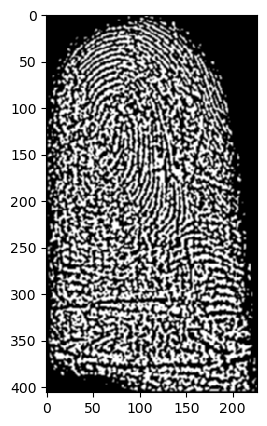

In [41]:
%time

im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
inv_image = invers_color(im)
crop_image = crop_fp_image(inv_image)

plt.imshow(crop_image)
plt.show()

# Function for getting image with golden propotion

In [45]:

def get_propotion(im):
    propotion = im.shape[0] / im.shape[1]
    return propotion

In [46]:

def get_golden_ratio_image(im):
    phi = (np.sqrt(5) + 1) / 2
    pr = get_propotion(im)

    if pr > phi:
        new_height = int(im.shape[1] * phi)
        new_im = im[:new_height, :]

        return new_im
    else:
        return im

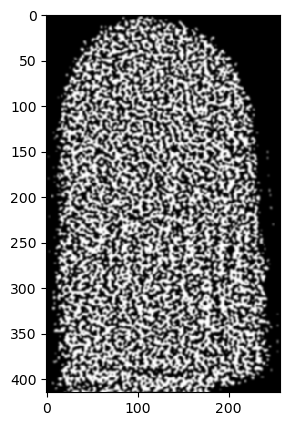

In [47]:

im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
inv_image = invers_color(im)
crop_image = crop_fp_image(inv_image)
golden_im = get_golden_ratio_image(crop_image)

plt.imshow(golden_im)
plt.show()
